In [ ]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('./drive')

Mounted at ./drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

In [ ]:
!cp 'drive/MyDrive/optimizer/data/R12.zip' R12.zip

In [ ]:
!unzip R12.zip

Archive:  R12.zip
  inflating: R12.txt                 


In [ ]:
!head R12.txt

3 300 3 3 0
1 1 1
116.770082611930210 -16.433219707325488 32.896692026637915
108.332973645536670 -10.595539308544826 43.874288053497168
106.965802355204150 0.914425874279254 25.464555454662886
112.197170997428630 -10.504401542069344 33.562826596589431
117.007398547001240 -11.651992040482591 23.136857374882805
104.265651876954390 3.622669628228325 27.372454550635794
106.775884755824450 -8.492049618463350 43.939220163738732
112.165889307365160 -8.870107824626281 30.521640240786958


In [ ]:
with open('R12.txt') as fp:
  line = fp.readline()
  line = line.split(' ')
  d, n, m, k, p = [int(item) for item in line]
  line = fp.readline()
  line = line.split(' ')
  K = [int(item) for item in line]


In [ ]:
!tail -n +3 R12.txt > R12_clean.txt

In [ ]:
vectors = np.fromfile('R12_clean.txt', sep=' ').reshape(n, -1)

In [ ]:
vectors

array([[ 1.16770083e+02, -1.64332197e+01,  3.28966920e+01],
       [ 1.08332974e+02, -1.05955393e+01,  4.38742881e+01],
       [ 1.06965802e+02,  9.14425874e-01,  2.54645555e+01],
       [ 1.12197171e+02, -1.05044015e+01,  3.35628266e+01],
       [ 1.17007399e+02, -1.16519920e+01,  2.31368574e+01],
       [ 1.04265652e+02,  3.62266963e+00,  2.73724546e+01],
       [ 1.06775885e+02, -8.49204962e+00,  4.39392202e+01],
       [ 1.12165889e+02, -8.87010782e+00,  3.05216402e+01],
       [ 1.11512400e+02, -5.82696380e+00,  2.64203329e+01],
       [ 1.16339964e+02, -1.25306750e+01,  2.65670231e+01],
       [ 1.06621137e+02, -8.27807075e-01,  2.96982768e+01],
       [ 1.10087629e+02, -3.91594987e+00,  2.65059808e+01],
       [ 1.12816299e+02, -9.42872226e+00,  2.98829152e+01],
       [ 1.15637855e+02, -1.18017308e+01,  2.70158630e+01],
       [ 1.13970930e+02, -1.08103729e+01,  2.94943003e+01],
       [ 1.15642781e+02, -1.73204757e+01,  3.75496507e+01],
       [ 1.17305042e+02, -1.77770955e+01

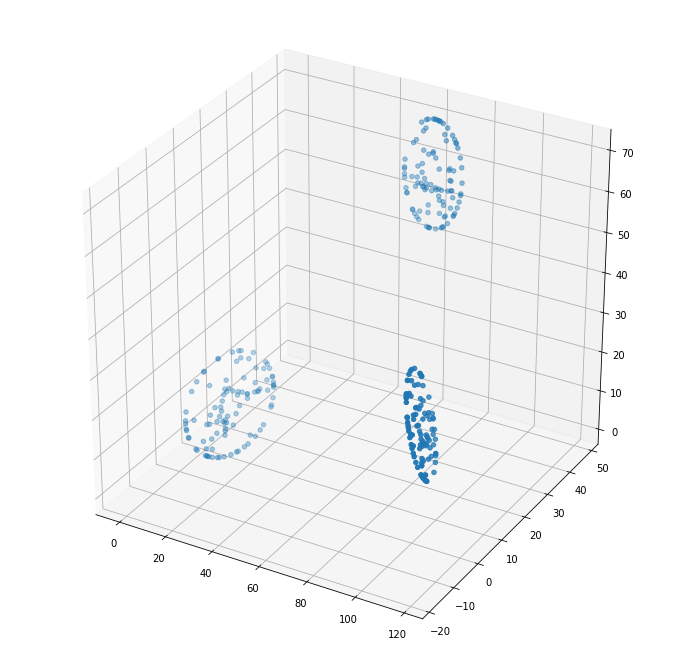

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')


ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2])
_ = plt.show()


In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=k, covariance_type='diag',
                      random_state=0)
gmm.fit(vectors)

GaussianMixture(covariance_type='diag', n_components=3, random_state=0)

In [ ]:
gmm.means_

array([[ 11.08110475,  10.87997042,   8.60057292],
       [111.23809234,  -8.12912425,  31.5395403 ],
       [ 60.945192  ,  46.91567703,  56.0453844 ]])

In [ ]:
labels = gmm.predict(vectors)

In [ ]:
def center_radius(points):
  dist = torch.cdist(points, points)
  ind = dist.argmax()
  row = (torch.div(ind, points.size(0), rounding_mode='floor')).item()
  col = (ind % points.size(0)).item()
  radius = (dist[row, col]/2).item()
  center = 0.5 * (points[row] + points[col])
  return center, radius


manifold_center = []
manifold_radius = []

for sphere in range(k):
  points = torch.from_numpy(vectors[labels==sphere])
  center, radius = center_radius(points)
  manifold_center.append(center)
  manifold_radius.append(radius)

manifold_center = np.vstack(manifold_center)

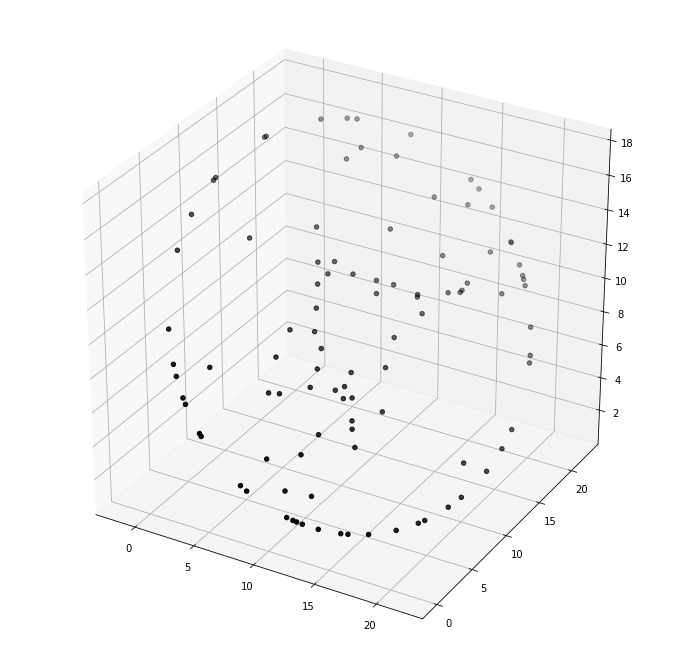

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

# t_colors = (S.flatten().abs() < 0.1).numpy() * 1
# ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2], c=t_colors)
# ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2], c=labels)
tv = vectors[labels==0]
ax.scatter(tv[:, 0], tv[:, 1], tv[:, 2], c='black')

# for sphere in range(k):
#   changed = manifold_center[sphere] + 10*affine_a[sphere]
#   ax.plot([manifold_center[sphere, 0], changed[0]],
#           [manifold_center[sphere, 1], changed[1]],
#           [manifold_center[sphere, 2], changed[2]], c='red')

_ = plt.show()

In [ ]:
from numba import njit

@njit
def get_best_fitting_plane_vector(centered):

    # Calculate the covariance matrix of the coordinates
    covariance_matrix = np.cov(centered, rowvar=False) # Variables = columns

    # Calculate the eigenvalues & eigenvectors of the covariance matrix
    e_val, e_vect = np.linalg.eig(covariance_matrix)

    # The normal vector to the plane is the eigenvector associated to the minimum eigenvalue
    min_eval = np.argmin(e_val)
    normal_vector = e_vect[:, min_eval]

    return normal_vector



In [ ]:
affine_a = []
affine_b = []

for sphere in tqdm(range(k)):
  points = vectors[labels==sphere]
  shift = points.mean(axis=0)
  centered = points - shift
  a = get_best_fitting_plane_vector(centered)
  b = a @ shift
  affine_a.append(a)
  affine_b.append(b)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
with open('output.txt', 'w+') as fp:
  fp.write(f'{n} {k}\n')
  for sphere in range(k):
    fp.write(f'2 {K[sphere]} Sphere\n')
    fp.write(' '.join(affine_a[sphere].astype(str).tolist()) + '\n')
    fp.write(f'{affine_b[sphere]}\n')
    vec_ind = np.where(labels == sphere)[0]
    fp.write(' '.join(manifold_center[0, :].astype(str).tolist()) + f' {manifold_radius[0]} \n')
    fp.write(f'{len(vec_ind)} ')
    fp.write(' '.join((vec_ind+1).astype(str).tolist()))
    fp.write('\n')
  fp.write(f'{p}')